## Isolation Forest

The goal of this notebook is to apply the Isolation Forest anomaly detection technique to the property data.

In [115]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer
from sklearn.ensemble import IsolationForest
import seaborn as sns
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('dark')

#### Load Data and Trim Columns

In [116]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_processed.h5')

# Fill na values in with 1 in crim_prop with 0 so they don't get dropped later on
df.loc[df.crim_prop==1,'price_psf'] = df.loc[df.crim_prop==1,'price_psf'].fillna(0)

trim_prop_df = df[(df.price_psf<df.price_psf.quantile(.999)) | (df.price_psf.isna())]

In [117]:
# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = trim_prop_df[variables_list]
df_if = sub_df.dropna()
print("Number of properties after trimming:", len(df_if))

Number of properties after trimming: 530923


In [118]:
# Get criminal property rate
crim_prop_rate = 1 - (len(df_if[df_if['crim_prop']==0]) / len(df_if))
print("Rate is: {:.5%}".format(crim_prop_rate))

Rate is: 0.00885%


In [119]:
# dfSA['binary_target'] = [1 if x==b'normal.' else -1 for x in dfSA[target]]
df_if['binary_y'] = [1 if x==0 else -1 for x in df_if.crim_prop]

/Users/matthewpokorny/anaconda3/envs/property_project_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [120]:
df_if.binary_y.value_counts()

 1    530876
-1        47
Name: binary_y, dtype: int64

In [121]:
# Normalize
X = df_if.iloc[:,:-2]
X_norm = preprocessing.normalize(X)

y = df_if.binary_y

# Split the data into train and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y, test_size=0.33, random_state=42
)

#### First Model - All Features Included

In [122]:
%%time
# Set parameters
clf = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

# Fit the model
clf.fit(X_train_norm,y_train_norm)
# Predict
y_pred_train = clf.predict(X_train_norm)

CPU times: user 36.7 s, sys: 5.56 s, total: 42.3 s
Wall time: 43.1 s


In [123]:
%%time
# Fit the model
clf.fit(X_train_norm,y_train_norm)
# Predict
y_pred_train = clf.predict(X_train_norm)

CPU times: user 36.4 s, sys: 5.28 s, total: 41.6 s
Wall time: 42.3 s


In [124]:
def plot_confusion_matrix(conf_matrix, title, classes=['criminally-linked', 'normal'],
                          cmap=plt.cm.Oranges, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=11)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=11)

    fmt = '.1%'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 fontsize=16,
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14, rotation=0)
    plt.xlabel('Predicted label',fontsize=14)
    
    if save:
        plt.savefig(saveas)

#### Model Performance on Training Data

In [125]:
print(recall_score(
    y_train_norm,
    y_pred_train,
    zero_division=0
))

0.9900137198893412


[[     6     24]
 [  3552 352136]]


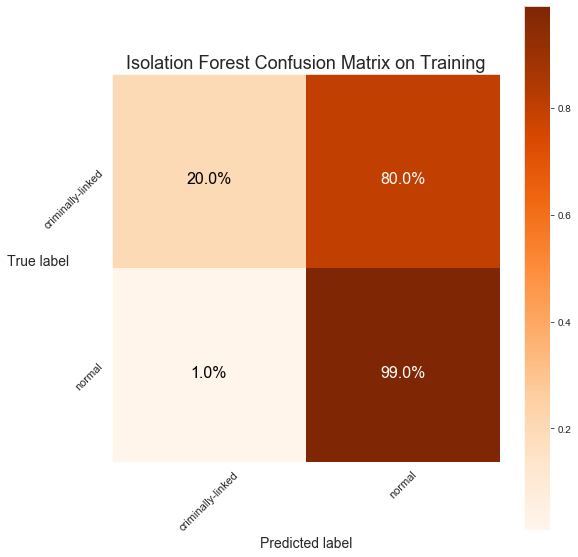

In [126]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training',save=False)

In [127]:
# Return classification report
print(classification_report(
    y_train_norm,
    y_pred_train,
    zero_division=0,
    digits=4,
    target_names=['criminally-linked', 'normal']
))
print ("AUC:", "{:.3%}".format(roc_auc_score(y_train_norm, y_pred_train)))

                   precision    recall  f1-score   support

criminally-linked     0.0017    0.2000    0.0033        30
           normal     0.9999    0.9900    0.9949    355688

         accuracy                         0.9899    355718
        macro avg     0.5008    0.5950    0.4991    355718
     weighted avg     0.9998    0.9899    0.9949    355718

AUC: 59.501%


The model performs quite poorly at the most important metric in a classification problem such as this, recall. Missing 80% of all criminally-linked properties makes for a bad anomaly detector.

#### Gridsearch

Isolation Forest is fairly robust to parameter changes, but different parameters may improve on the first attempt's poor performance.

In [106]:
%%time
skip = 1
if skip == 0:
    # Set what metrics to evaluate predictions
    scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

    gs = GridSearchCV(
        IsolationForest(max_samples=0.25, random_state=42,n_estimators=100),
        param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
        scoring=scoring, 
        refit='Recall',
        verbose=0,
        cv=3
    )
    
    # Fit to training data
    gs.fit(X_train_norm,y_train_norm)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] contamination=0.01 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... contamination=0.01, AUC=0.971, Recall=0.385, total=  37.0s
[CV] contamination=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.0s remaining:    0.0s


[CV] ...... contamination=0.01, AUC=0.953, Recall=0.000, total=  31.8s
[CV] contamination=0.01 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] ...... contamination=0.01, AUC=0.946, Recall=0.100, total=  29.3s
[CV] contamination=0.060000000000000005 ..............................
[CV]  contamination=0.060000000000000005, AUC=0.971, Recall=0.846, total=  25.9s
[CV] contamination=0.060000000000000005 ..............................
[CV]  contamination=0.060000000000000005, AUC=0.953, Recall=0.571, total=  26.4s
[CV] contamination=0.060000000000000005 ..............................
[CV]  contamination=0.060000000000000005, AUC=0.946, Recall=0.800, total=  26.3s
[CV] contamination=0.11 ..............................................
[CV] ...... contamination=0.11, AUC=0.971, Recall=1.000, total=  28.7s
[CV] contamination=0.11 ..............................................
[CV] ...... contamination=0.11, AUC=0.953, Recall=1.000, total=  28.6s
[CV] contamination=0.11 ..............................................
[CV] ...... contamination=0.11, AUC=0.946, Recall=0.900, total=  27.8s
[CV] contamination=0.16000000000000003 ........

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  7.2min finished


CPU times: user 6min 14s, sys: 54.4 s, total: 7min 9s
Wall time: 7min 41s


GridSearchCV(cv=3, error_score=nan,
             estimator=IsolationForest(behaviour='deprecated', bootstrap=False,
                                       contamination='auto', max_features=1.0,
                                       max_samples=0.25, n_estimators=100,
                                       n_jobs=None, random_state=42, verbose=0,
                                       warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'contamination': array([0.01, 0.06, 0.11, 0.16, 0.21])},
             pre_dispatch='2*n_jobs', refit='Recall', return_train_score=False,
             scoring={'AUC': 'roc_auc',
                      'Recall': make_scorer(recall_score, pos_label=-1)},
             verbose=3)

In [128]:
gs.best_params_

{'contamination': 0.11}

#### Gridsearch Model

In [113]:
%%time
clf_gs = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.11,
    random_state=42
)

clf_gs.fit(X_train_norm,y_train_norm)
y_pred_train_gs = clf_gs.predict(X_train_norm)

CPU times: user 36.6 s, sys: 5.24 s, total: 41.9 s
Wall time: 42.5 s


0.8900693866534716
[[    28      2]
 [ 39101 316587]]


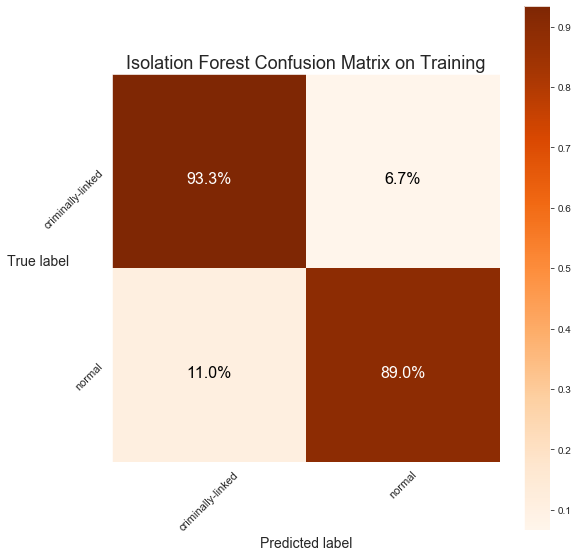

In [114]:
print(recall_score(
    y_train_norm,
    y_pred_train_gs,
    zero_division=0
))

conf_matrix = confusion_matrix(y_train_norm, y_pred_train_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Training',save=False)

Increasing the contamination parameter, drastically improved the model's recall. Let's see if it holds up on testing data.

0.8898326369386031
[[    13      4]
 [ 19300 155888]]


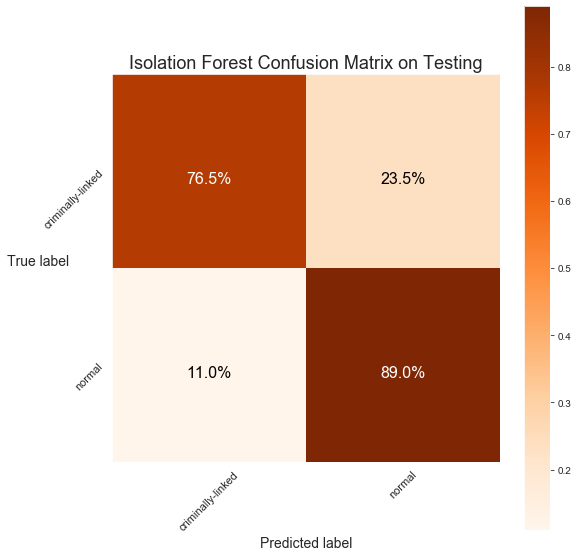

In [129]:
y_pred_test_gs = clf_gs.predict(X_test_norm)

print(recall_score(
    y_test_norm,
    y_pred_test_gs,
    zero_division=0
))

conf_matrix = confusion_matrix(y_test_norm, y_pred_test_gs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Testing',save=False)

The model does a bit worse on testing but still better than the first attempt's performance. While the model now detects 28 out of 30 criminally-linked properties correctly on the training data, it has done so at the expense of increasing false positives from 3,552 for the first model to 39,101 for the grid-searched model. In this case of criminal investment in residential real estate, it is a tradeoff worth making.

In [134]:
scores_training = clf_gs.decision_function(X_train_norm)

In [150]:
len(y_train_norm)

355718

In [151]:
len(scores_training)

355718

In [153]:
y_train_norm[y_train_norm==-1].index

Int64Index([ 95165, 482785, 562754, 512360, 552967, 547027,  94760, 510328,
             87260, 509891, 552954, 516525, 547244, 500264, 543403, 562757,
            512361, 463299, 543519,  94761, 482800, 562758, 391804, 562764,
            551310,  94696,  94705, 537061, 537053, 465859],
           dtype='int64')

In [191]:
scores_training.shape

(355718,)

In [176]:
train_df = pd.DataFrame(X_train_norm)

In [186]:
y.reset_index()['binary_y'].value_counts()

 1    530876
-1        47
Name: binary_y, dtype: int64

In [205]:
# Put back into df in order to grab anomaly scores for criminally-linked properties
train_df = pd.DataFrame(X_train_norm)
y_train_series = y_train_norm.reset_index()
train_df['y_value'] = y_train_series.binary_y
train_df['anomaly_scores'] = scores_training
anomaly_scores_list = train_df[train_df.y_value==-1]['anomaly_scores'].values

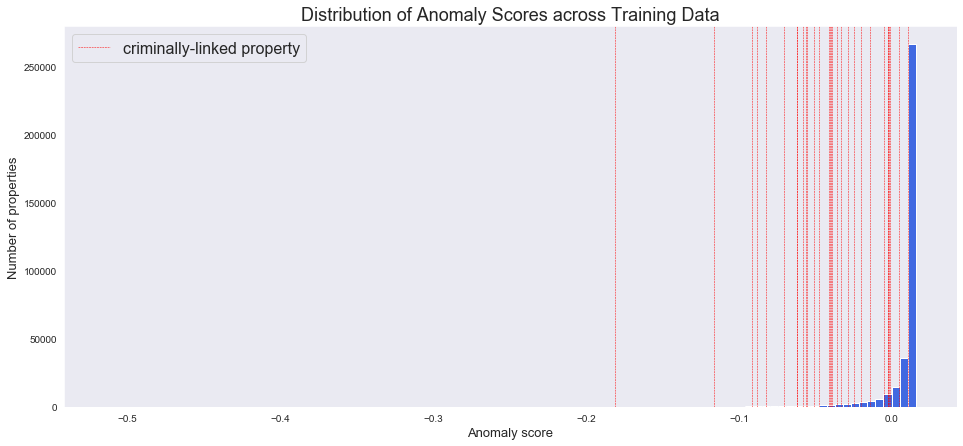

In [244]:
plt.figure(figsize=(16,7))
plt.hist(scores_training,bins=100,log=False,color='royalblue')
for xc in anomaly_scores_list:
    plt.axvline(x=xc,color='red',linestyle='--',linewidth=0.5,label='criminally-linked property')
plt.xlabel('Anomaly score',fontsize=13)
plt.ylabel('Number of properties',fontsize=13)
plt.title('Distribution of Anomaly Scores across Training Data',fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),fontsize=16)
plt.show()